In [1]:
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')

In [2]:
trainy = pd.read_csv("./pretrained/trainy_pre.csv")
valy = pd.read_csv("./pretrained/valy_pre.csv")
#labels to categorical matrix
le = preprocessing.LabelEncoder()
le.fit(trainy['celltype'])
classes = len(np.unique(trainy['celltype']))
with open("./pretrained/label_encoder_pre.obj","wb") as f:
   pickle.dump(le, f)

y_train = pd.DataFrame(le.transform(trainy['celltype']))
y_val = pd.DataFrame(le.transform(valy['celltype']))
np.save('./pretrained/train_pre_label.npy', y_train)
np.save('./pretrained/val_pre_label.npy', y_val)

In [3]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = torch.nn.functional.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * torch.nn.functional.nll_loss(log_preds, target, reduction=self.reduction)


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./pretrained/checkpoint_model_pre.pth'):
        self.patience = patience    
        self.verbose = verbose      
        self.counter = 0            
        self.best_score = None      
        self.early_stop = False     
        self.val_acc_max = 0   
        self.path = path             
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None: 
            self.best_score = score 
            self.checkpoint(val_acc, model)
        elif score < self.best_score: 
            self.counter += 1 
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_acc, model)
            self.counter = 0  
    def checkpoint(self, val_acc, model):
        if self.verbose:  
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  
        self.val_acc_max = val_acc  

In [5]:
class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = np.load(img)
        self.label = torch.tensor(np.load(label))
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :] 
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        label = self.label[index]
        label = np.squeeze(label)
        return img,label
    def __len__(self):
        return self.img.shape[0]

In [6]:
def train_net(pre_epoch, EPOCH, early_patience, training_loader, validation_loader, net, optimizer, scheduler, criteria, device):
    with open("./pretrained/acc.txt", "w") as f:
        with open("./pretrained/log.txt", "w")as f2:
            start = time.time()
            earlystopping = EarlyStopping(patience=early_patience, verbose=True)
            losses_train = []
            accs_train = []
            losses_val = []
            accs_val = []
            best_acc = 0
            total_poches = 0
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                since = time.time()
                net.train()
                sum_loss = 0.0
                correct = 0
                total = 0
                for i, data in enumerate(training_loader):
                    length = len(training_loader)
                    input, target = data
                    input, target = input.to(device), target.to(device)
                    optimizer.zero_grad()
                    # forward + backward
                    output = net(input)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += predicted.eq(target.data).cpu().sum()
                    loss_train = sum_loss / (i + 1)
                    acc_train = 100. * float(correct) / float(total)
                    print('[epoch:%d, iter:%d] Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('%03d  %05d |Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('\n')
                    f2.flush()
                acc_train = 100. * float(correct) / float(total)
                accs_train.append(acc_train)
                losses_train.append(loss_train)
                print("Waiting Test!")
                with torch.no_grad():
                    sum_loss_val = 0
                    correct = 0
                    total = 0
                    loss_val = 0
                    for i, data in enumerate(validation_loader):
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criteria(outputs, labels)
                        sum_loss_val += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += predicted.eq(labels.data).cpu().sum()
                        loss_val = sum_loss_val / (i + 1)
                    acc_val = 100. * float(correct) / float(total)
                    losses_val.append(loss_val)
                    accs_val.append(acc_val)
                    print("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    scheduler.step(acc_val)
                    if acc_val > best_acc:
                        f3 = open("./pretrained/best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc_val))
                        f3.close()
                        best_acc = acc_val
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    earlystopping(acc_val, net)
                    if earlystopping.early_stop: 
                        print("Early Stopping!")
                        total_poches = epoch + 1
                        break
            print("Training Finished, TotalEPOCH=%d" % total_poches)
            time_total = time.time() - start
            print('The whole training process complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    return losses_train, accs_train, losses_val, accs_val

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
batch_size = 32
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
net._fc.out_features = classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

Loaded pretrained weights for efficientnet-b3


'Quadro RTX 8000'

In [8]:
net.to(device)
net = net.to(device)

In [9]:
train = MyDataset("./pretrained/train_pre.npy", "./pretrained/train_pre_label.npy")
training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = MyDataset("./pretrained/val_pre.npy", "./pretrained/val_pre_label.npy")
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:
LR = 3e-4 
# optimizer
params_to_update = net.parameters()
optimizer = optim.NAdam(params_to_update, lr=LR, betas=(0.9, 0.999), eps=1e-9)
# scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
criteria = LabelSmoothingCrossEntropy(0.1)

In [11]:
start = timer()

In [12]:
losses_train, accs_train, losses_val, accs_val = train_net(pre_epoch=0,
                                                           EPOCH = 100,
                                                           early_patience = 30,
                                                           training_loader=training_loader,
                                                           validation_loader = validation_loader,
                                                           net=net,
                                                           optimizer=optimizer,
                                                           scheduler=scheduler,
                                                           criteria=criteria,
                                                           device=device
                                                        )


Epoch: 1
[epoch:1, iter:1] Loss: 2.306 | Accuracy: 9.375% 
[epoch:1, iter:2] Loss: 2.267 | Accuracy: 20.312% 
[epoch:1, iter:3] Loss: 2.228 | Accuracy: 28.125% 
[epoch:1, iter:4] Loss: 2.194 | Accuracy: 29.688% 
[epoch:1, iter:5] Loss: 2.163 | Accuracy: 33.125% 
[epoch:1, iter:6] Loss: 2.125 | Accuracy: 37.500% 
[epoch:1, iter:7] Loss: 2.075 | Accuracy: 42.411% 
[epoch:1, iter:8] Loss: 2.022 | Accuracy: 45.703% 
[epoch:1, iter:9] Loss: 2.004 | Accuracy: 45.833% 
[epoch:1, iter:10] Loss: 1.948 | Accuracy: 49.375% 
[epoch:1, iter:11] Loss: 1.909 | Accuracy: 50.000% 
[epoch:1, iter:12] Loss: 1.880 | Accuracy: 51.042% 
[epoch:1, iter:13] Loss: 1.826 | Accuracy: 52.163% 
[epoch:1, iter:14] Loss: 1.777 | Accuracy: 54.464% 
[epoch:1, iter:15] Loss: 1.728 | Accuracy: 56.667% 
[epoch:1, iter:16] Loss: 1.683 | Accuracy: 58.008% 
[epoch:1, iter:17] Loss: 1.644 | Accuracy: 59.375% 
[epoch:1, iter:18] Loss: 1.620 | Accuracy: 60.069% 
[epoch:1, iter:19] Loss: 1.577 | Accuracy: 61.678% 
[epoch:1, it

[epoch:3, iter:153] Loss: 0.573 | Accuracy: 98.295% 
[epoch:3, iter:154] Loss: 0.572 | Accuracy: 98.346% 
[epoch:3, iter:155] Loss: 0.570 | Accuracy: 98.393% 
[epoch:3, iter:156] Loss: 0.570 | Accuracy: 98.351% 
[epoch:3, iter:157] Loss: 0.574 | Accuracy: 98.057% 
[epoch:3, iter:158] Loss: 0.574 | Accuracy: 98.109% 
[epoch:3, iter:159] Loss: 0.575 | Accuracy: 98.077% 
[epoch:3, iter:160] Loss: 0.574 | Accuracy: 98.125% 
[epoch:3, iter:161] Loss: 0.579 | Accuracy: 98.018% 
[epoch:3, iter:162] Loss: 0.581 | Accuracy: 97.991% 
[epoch:3, iter:163] Loss: 0.581 | Accuracy: 97.965% 
[epoch:3, iter:164] Loss: 0.584 | Accuracy: 97.727% 
[epoch:3, iter:165] Loss: 0.584 | Accuracy: 97.778% 
[epoch:3, iter:166] Loss: 0.583 | Accuracy: 97.826% 
[epoch:3, iter:167] Loss: 0.582 | Accuracy: 97.806% 
[epoch:3, iter:168] Loss: 0.585 | Accuracy: 97.721% 
[epoch:3, iter:169] Loss: 0.584 | Accuracy: 97.768% 
[epoch:3, iter:170] Loss: 0.585 | Accuracy: 97.688% 
[epoch:3, iter:171] Loss: 0.589 | Accuracy: 97


Epoch: 6
[epoch:6, iter:301] Loss: 0.524 | Accuracy: 100.000% 
[epoch:6, iter:302] Loss: 0.520 | Accuracy: 100.000% 
[epoch:6, iter:303] Loss: 0.517 | Accuracy: 100.000% 
[epoch:6, iter:304] Loss: 0.526 | Accuracy: 99.219% 
[epoch:6, iter:305] Loss: 0.522 | Accuracy: 99.375% 
[epoch:6, iter:306] Loss: 0.524 | Accuracy: 99.479% 
[epoch:6, iter:307] Loss: 0.534 | Accuracy: 99.107% 
[epoch:6, iter:308] Loss: 0.538 | Accuracy: 98.828% 
[epoch:6, iter:309] Loss: 0.549 | Accuracy: 98.611% 
[epoch:6, iter:310] Loss: 0.547 | Accuracy: 98.750% 
[epoch:6, iter:311] Loss: 0.547 | Accuracy: 98.580% 
[epoch:6, iter:312] Loss: 0.545 | Accuracy: 98.698% 
[epoch:6, iter:313] Loss: 0.546 | Accuracy: 98.558% 
[epoch:6, iter:314] Loss: 0.544 | Accuracy: 98.661% 
[epoch:6, iter:315] Loss: 0.548 | Accuracy: 98.333% 
[epoch:6, iter:316] Loss: 0.546 | Accuracy: 98.438% 
[epoch:6, iter:317] Loss: 0.544 | Accuracy: 98.529% 
[epoch:6, iter:318] Loss: 0.544 | Accuracy: 98.438% 
[epoch:6, iter:319] Loss: 0.542 |

[epoch:8, iter:451] Loss: 0.519 | Accuracy: 99.698% 
[epoch:8, iter:452] Loss: 0.519 | Accuracy: 99.707% 
[epoch:8, iter:453] Loss: 0.519 | Accuracy: 99.716% 
[epoch:8, iter:454] Loss: 0.519 | Accuracy: 99.724% 
[epoch:8, iter:455] Loss: 0.519 | Accuracy: 99.732% 
[epoch:8, iter:456] Loss: 0.520 | Accuracy: 99.653% 
[epoch:8, iter:457] Loss: 0.520 | Accuracy: 99.662% 
[epoch:8, iter:458] Loss: 0.519 | Accuracy: 99.671% 
[epoch:8, iter:459] Loss: 0.519 | Accuracy: 99.679% 
[epoch:8, iter:460] Loss: 0.519 | Accuracy: 99.688% 
[epoch:8, iter:461] Loss: 0.521 | Accuracy: 99.619% 
[epoch:8, iter:462] Loss: 0.522 | Accuracy: 99.628% 
[epoch:8, iter:463] Loss: 0.521 | Accuracy: 99.637% 
[epoch:8, iter:464] Loss: 0.521 | Accuracy: 99.645% 
[epoch:8, iter:465] Loss: 0.521 | Accuracy: 99.653% 
[epoch:8, iter:466] Loss: 0.521 | Accuracy: 99.660% 
[epoch:8, iter:467] Loss: 0.520 | Accuracy: 99.668% 
[epoch:8, iter:468] Loss: 0.520 | Accuracy: 99.674% 
[epoch:8, iter:469] Loss: 0.520 | Accuracy: 99

[epoch:10, iter:600] Loss: 0.517 | Accuracy: 99.686% 
Waiting Test!
EPOCH=010, Loss: 0.670, Accuracy= 93.333%
Training complete in 0m 10s
Validation accuracy increased (80.000000 --> 93.333333).  Saving model ...

Epoch: 11
[epoch:11, iter:601] Loss: 0.509 | Accuracy: 100.000% 
[epoch:11, iter:602] Loss: 0.507 | Accuracy: 100.000% 
[epoch:11, iter:603] Loss: 0.509 | Accuracy: 100.000% 
[epoch:11, iter:604] Loss: 0.508 | Accuracy: 100.000% 
[epoch:11, iter:605] Loss: 0.508 | Accuracy: 100.000% 
[epoch:11, iter:606] Loss: 0.508 | Accuracy: 100.000% 
[epoch:11, iter:607] Loss: 0.508 | Accuracy: 100.000% 
[epoch:11, iter:608] Loss: 0.508 | Accuracy: 100.000% 
[epoch:11, iter:609] Loss: 0.508 | Accuracy: 100.000% 
[epoch:11, iter:610] Loss: 0.507 | Accuracy: 100.000% 
[epoch:11, iter:611] Loss: 0.507 | Accuracy: 100.000% 
[epoch:11, iter:612] Loss: 0.507 | Accuracy: 100.000% 
[epoch:11, iter:613] Loss: 0.508 | Accuracy: 100.000% 
[epoch:11, iter:614] Loss: 0.513 | Accuracy: 99.777% 
[epoch:

[epoch:13, iter:743] Loss: 0.525 | Accuracy: 99.321% 
[epoch:13, iter:744] Loss: 0.525 | Accuracy: 99.219% 
[epoch:13, iter:745] Loss: 0.525 | Accuracy: 99.250% 
[epoch:13, iter:746] Loss: 0.525 | Accuracy: 99.279% 
[epoch:13, iter:747] Loss: 0.525 | Accuracy: 99.306% 
[epoch:13, iter:748] Loss: 0.524 | Accuracy: 99.330% 
[epoch:13, iter:749] Loss: 0.524 | Accuracy: 99.353% 
[epoch:13, iter:750] Loss: 0.523 | Accuracy: 99.375% 
[epoch:13, iter:751] Loss: 0.523 | Accuracy: 99.395% 
[epoch:13, iter:752] Loss: 0.523 | Accuracy: 99.414% 
[epoch:13, iter:753] Loss: 0.522 | Accuracy: 99.432% 
[epoch:13, iter:754] Loss: 0.526 | Accuracy: 99.265% 
[epoch:13, iter:755] Loss: 0.526 | Accuracy: 99.286% 
[epoch:13, iter:756] Loss: 0.526 | Accuracy: 99.306% 
[epoch:13, iter:757] Loss: 0.525 | Accuracy: 99.324% 
[epoch:13, iter:758] Loss: 0.525 | Accuracy: 99.342% 
[epoch:13, iter:759] Loss: 0.525 | Accuracy: 99.359% 
[epoch:13, iter:760] Loss: 0.524 | Accuracy: 99.375% 
[epoch:13, iter:761] Loss: 0

[epoch:15, iter:889] Loss: 0.509 | Accuracy: 99.936% 
[epoch:15, iter:890] Loss: 0.509 | Accuracy: 99.938% 
[epoch:15, iter:891] Loss: 0.509 | Accuracy: 99.939% 
[epoch:15, iter:892] Loss: 0.509 | Accuracy: 99.940% 
[epoch:15, iter:893] Loss: 0.509 | Accuracy: 99.941% 
[epoch:15, iter:894] Loss: 0.509 | Accuracy: 99.942% 
[epoch:15, iter:895] Loss: 0.509 | Accuracy: 99.943% 
[epoch:15, iter:896] Loss: 0.509 | Accuracy: 99.944% 
[epoch:15, iter:897] Loss: 0.509 | Accuracy: 99.945% 
[epoch:15, iter:898] Loss: 0.509 | Accuracy: 99.946% 
[epoch:15, iter:899] Loss: 0.509 | Accuracy: 99.947% 
[epoch:15, iter:900] Loss: 0.510 | Accuracy: 99.948% 
Waiting Test!
EPOCH=015, Loss: 0.571, Accuracy= 97.143%
Training complete in 0m 10s
Validation accuracy increased (97.142857 --> 97.142857).  Saving model ...

Epoch: 16
[epoch:16, iter:901] Loss: 0.503 | Accuracy: 100.000% 
[epoch:16, iter:902] Loss: 0.507 | Accuracy: 100.000% 
[epoch:16, iter:903] Loss: 0.506 | Accuracy: 100.000% 
[epoch:16, iter:9

[epoch:18, iter:1032] Loss: 0.506 | Accuracy: 100.000% 
[epoch:18, iter:1033] Loss: 0.506 | Accuracy: 100.000% 
[epoch:18, iter:1034] Loss: 0.506 | Accuracy: 100.000% 
[epoch:18, iter:1035] Loss: 0.506 | Accuracy: 100.000% 
[epoch:18, iter:1036] Loss: 0.510 | Accuracy: 99.805% 
[epoch:18, iter:1037] Loss: 0.509 | Accuracy: 99.816% 
[epoch:18, iter:1038] Loss: 0.509 | Accuracy: 99.826% 
[epoch:18, iter:1039] Loss: 0.509 | Accuracy: 99.836% 
[epoch:18, iter:1040] Loss: 0.509 | Accuracy: 99.844% 
[epoch:18, iter:1041] Loss: 0.509 | Accuracy: 99.851% 
[epoch:18, iter:1042] Loss: 0.509 | Accuracy: 99.858% 
[epoch:18, iter:1043] Loss: 0.516 | Accuracy: 99.592% 
[epoch:18, iter:1044] Loss: 0.516 | Accuracy: 99.609% 
[epoch:18, iter:1045] Loss: 0.517 | Accuracy: 99.500% 
[epoch:18, iter:1046] Loss: 0.517 | Accuracy: 99.519% 
[epoch:18, iter:1047] Loss: 0.516 | Accuracy: 99.537% 
[epoch:18, iter:1048] Loss: 0.516 | Accuracy: 99.554% 
[epoch:18, iter:1049] Loss: 0.516 | Accuracy: 99.569% 
[epoch

[epoch:20, iter:1174] Loss: 0.505 | Accuracy: 100.000% 
[epoch:20, iter:1175] Loss: 0.505 | Accuracy: 100.000% 
[epoch:20, iter:1176] Loss: 0.505 | Accuracy: 100.000% 
[epoch:20, iter:1177] Loss: 0.505 | Accuracy: 100.000% 
[epoch:20, iter:1178] Loss: 0.505 | Accuracy: 100.000% 
[epoch:20, iter:1179] Loss: 0.507 | Accuracy: 99.920% 
[epoch:20, iter:1180] Loss: 0.507 | Accuracy: 99.922% 
[epoch:20, iter:1181] Loss: 0.507 | Accuracy: 99.924% 
[epoch:20, iter:1182] Loss: 0.507 | Accuracy: 99.926% 
[epoch:20, iter:1183] Loss: 0.507 | Accuracy: 99.927% 
[epoch:20, iter:1184] Loss: 0.507 | Accuracy: 99.929% 
[epoch:20, iter:1185] Loss: 0.507 | Accuracy: 99.931% 
[epoch:20, iter:1186] Loss: 0.507 | Accuracy: 99.932% 
[epoch:20, iter:1187] Loss: 0.507 | Accuracy: 99.934% 
[epoch:20, iter:1188] Loss: 0.507 | Accuracy: 99.935% 
[epoch:20, iter:1189] Loss: 0.507 | Accuracy: 99.936% 
[epoch:20, iter:1190] Loss: 0.508 | Accuracy: 99.875% 
[epoch:20, iter:1191] Loss: 0.508 | Accuracy: 99.877% 
[epoc

[epoch:22, iter:1317] Loss: 0.509 | Accuracy: 99.781% 
[epoch:22, iter:1318] Loss: 0.509 | Accuracy: 99.784% 
[epoch:22, iter:1319] Loss: 0.509 | Accuracy: 99.788% 
[epoch:22, iter:1320] Loss: 0.509 | Accuracy: 99.791% 
Waiting Test!
EPOCH=022, Loss: 0.570, Accuracy= 98.095%
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 23
[epoch:23, iter:1321] Loss: 0.503 | Accuracy: 100.000% 
[epoch:23, iter:1322] Loss: 0.504 | Accuracy: 100.000% 
[epoch:23, iter:1323] Loss: 0.504 | Accuracy: 100.000% 
[epoch:23, iter:1324] Loss: 0.504 | Accuracy: 100.000% 
[epoch:23, iter:1325] Loss: 0.504 | Accuracy: 100.000% 
[epoch:23, iter:1326] Loss: 0.504 | Accuracy: 100.000% 
[epoch:23, iter:1327] Loss: 0.504 | Accuracy: 100.000% 
[epoch:23, iter:1328] Loss: 0.504 | Accuracy: 100.000% 
[epoch:23, iter:1329] Loss: 0.504 | Accuracy: 100.000% 
[epoch:23, iter:1330] Loss: 0.505 | Accuracy: 100.000% 
[epoch:23, iter:1331] Loss: 0.505 | Accuracy: 100.

[epoch:25, iter:1455] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1456] Loss: 0.506 | Accuracy: 100.000% 
[epoch:25, iter:1457] Loss: 0.506 | Accuracy: 100.000% 
[epoch:25, iter:1458] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1459] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1460] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1461] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1462] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1463] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1464] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1465] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1466] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1467] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1468] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1469] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1470] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1471] Loss: 0.505 | Accuracy: 100.000% 
[epoch:25, iter:1472] Loss: 0.505 | Accuracy: 10

[epoch:27, iter:1596] Loss: 0.504 | Accuracy: 100.000% 
[epoch:27, iter:1597] Loss: 0.503 | Accuracy: 100.000% 
[epoch:27, iter:1598] Loss: 0.503 | Accuracy: 100.000% 
[epoch:27, iter:1599] Loss: 0.503 | Accuracy: 100.000% 
[epoch:27, iter:1600] Loss: 0.503 | Accuracy: 100.000% 
[epoch:27, iter:1601] Loss: 0.503 | Accuracy: 100.000% 
[epoch:27, iter:1602] Loss: 0.503 | Accuracy: 100.000% 
[epoch:27, iter:1603] Loss: 0.503 | Accuracy: 100.000% 
[epoch:27, iter:1604] Loss: 0.503 | Accuracy: 100.000% 
[epoch:27, iter:1605] Loss: 0.504 | Accuracy: 99.931% 
[epoch:27, iter:1606] Loss: 0.504 | Accuracy: 99.932% 
[epoch:27, iter:1607] Loss: 0.504 | Accuracy: 99.934% 
[epoch:27, iter:1608] Loss: 0.504 | Accuracy: 99.935% 
[epoch:27, iter:1609] Loss: 0.504 | Accuracy: 99.936% 
[epoch:27, iter:1610] Loss: 0.504 | Accuracy: 99.938% 
[epoch:27, iter:1611] Loss: 0.504 | Accuracy: 99.939% 
[epoch:27, iter:1612] Loss: 0.504 | Accuracy: 99.940% 
[epoch:27, iter:1613] Loss: 0.504 | Accuracy: 99.941% 
[

[epoch:29, iter:1739] Loss: 0.505 | Accuracy: 99.947% 
[epoch:29, iter:1740] Loss: 0.505 | Accuracy: 99.948% 
Waiting Test!
EPOCH=029, Loss: 0.569, Accuracy= 98.095%
Epoch 00029: reducing learning rate of group 0 to 1.0290e-04.
Training complete in 0m 10s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 30
[epoch:30, iter:1741] Loss: 0.503 | Accuracy: 100.000% 
[epoch:30, iter:1742] Loss: 0.504 | Accuracy: 100.000% 
[epoch:30, iter:1743] Loss: 0.504 | Accuracy: 100.000% 
[epoch:30, iter:1744] Loss: 0.504 | Accuracy: 100.000% 
[epoch:30, iter:1745] Loss: 0.504 | Accuracy: 100.000% 
[epoch:30, iter:1746] Loss: 0.504 | Accuracy: 100.000% 
[epoch:30, iter:1747] Loss: 0.504 | Accuracy: 100.000% 
[epoch:30, iter:1748] Loss: 0.504 | Accuracy: 100.000% 
[epoch:30, iter:1749] Loss: 0.503 | Accuracy: 100.000% 
[epoch:30, iter:1750] Loss: 0.504 | Accuracy: 100.000% 
[epoch:30, iter:1751] Loss: 0.503 | Accuracy: 100.000% 
[epoch:30, iter:1752] Loss: 0.503 | Accura

[epoch:32, iter:1878] Loss: 0.509 | Accuracy: 99.826% 
[epoch:32, iter:1879] Loss: 0.509 | Accuracy: 99.836% 
[epoch:32, iter:1880] Loss: 0.509 | Accuracy: 99.844% 
[epoch:32, iter:1881] Loss: 0.508 | Accuracy: 99.851% 
[epoch:32, iter:1882] Loss: 0.508 | Accuracy: 99.858% 
[epoch:32, iter:1883] Loss: 0.508 | Accuracy: 99.864% 
[epoch:32, iter:1884] Loss: 0.508 | Accuracy: 99.870% 
[epoch:32, iter:1885] Loss: 0.508 | Accuracy: 99.875% 
[epoch:32, iter:1886] Loss: 0.507 | Accuracy: 99.880% 
[epoch:32, iter:1887] Loss: 0.507 | Accuracy: 99.884% 
[epoch:32, iter:1888] Loss: 0.507 | Accuracy: 99.888% 
[epoch:32, iter:1889] Loss: 0.507 | Accuracy: 99.892% 
[epoch:32, iter:1890] Loss: 0.507 | Accuracy: 99.896% 
[epoch:32, iter:1891] Loss: 0.507 | Accuracy: 99.899% 
[epoch:32, iter:1892] Loss: 0.507 | Accuracy: 99.902% 
[epoch:32, iter:1893] Loss: 0.506 | Accuracy: 99.905% 
[epoch:32, iter:1894] Loss: 0.506 | Accuracy: 99.908% 
[epoch:32, iter:1895] Loss: 0.506 | Accuracy: 99.911% 
[epoch:32,

[epoch:34, iter:2019] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2020] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2021] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2022] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2023] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2024] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2025] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2026] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2027] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2028] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2029] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2030] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2031] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2032] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2033] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2034] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2035] Loss: 0.503 | Accuracy: 100.000% 
[epoch:34, iter:2036] Loss: 0.503 | Accuracy: 10

EPOCH=036, Loss: 0.565, Accuracy= 98.095%
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 37
[epoch:37, iter:2161] Loss: 0.502 | Accuracy: 100.000% 
[epoch:37, iter:2162] Loss: 0.502 | Accuracy: 100.000% 
[epoch:37, iter:2163] Loss: 0.502 | Accuracy: 100.000% 
[epoch:37, iter:2164] Loss: 0.502 | Accuracy: 100.000% 
[epoch:37, iter:2165] Loss: 0.502 | Accuracy: 100.000% 
[epoch:37, iter:2166] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2167] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2168] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2169] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2170] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2171] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2172] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2173] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2174] Loss: 0.503 | Accuracy: 100.000% 
[epoch:37, iter:2175] Loss: 0.503 | Accuracy: 100.000% 
[epo

[epoch:39, iter:2298] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2299] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2300] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2301] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2302] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2303] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2304] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2305] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2306] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2307] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2308] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2309] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2310] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2311] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2312] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2313] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2314] Loss: 0.503 | Accuracy: 100.000% 
[epoch:39, iter:2315] Loss: 0.503 | Accuracy: 10

[epoch:41, iter:2440] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2441] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2442] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2443] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2444] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2445] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2446] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2447] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2448] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2449] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2450] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2451] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2452] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2453] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2454] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2455] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2456] Loss: 0.502 | Accuracy: 100.000% 
[epoch:41, iter:2457] Loss: 0.502 | Accuracy: 10

EPOCH=043, Loss: 0.566, Accuracy= 98.095%
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 44
[epoch:44, iter:2581] Loss: 0.502 | Accuracy: 100.000% 
[epoch:44, iter:2582] Loss: 0.507 | Accuracy: 100.000% 
[epoch:44, iter:2583] Loss: 0.507 | Accuracy: 100.000% 
[epoch:44, iter:2584] Loss: 0.506 | Accuracy: 100.000% 
[epoch:44, iter:2585] Loss: 0.505 | Accuracy: 100.000% 
[epoch:44, iter:2586] Loss: 0.505 | Accuracy: 100.000% 
[epoch:44, iter:2587] Loss: 0.504 | Accuracy: 100.000% 
[epoch:44, iter:2588] Loss: 0.504 | Accuracy: 100.000% 
[epoch:44, iter:2589] Loss: 0.504 | Accuracy: 100.000% 
[epoch:44, iter:2590] Loss: 0.504 | Accuracy: 100.000% 
[epoch:44, iter:2591] Loss: 0.504 | Accuracy: 100.000% 
[epoch:44, iter:2592] Loss: 0.503 | Accuracy: 100.000% 
[epoch:44, iter:2593] Loss: 0.503 | Accuracy: 100.000% 
[epoch:44, iter:2594] Loss: 0.503 | Accuracy: 100.000% 
[epoch:44, iter:2595] Loss: 0.503 | Accuracy: 100.000% 
[epo

[epoch:46, iter:2718] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2719] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2720] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2721] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2722] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2723] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2724] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2725] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2726] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2727] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2728] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2729] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2730] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2731] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2732] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2733] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2734] Loss: 0.502 | Accuracy: 100.000% 
[epoch:46, iter:2735] Loss: 0.502 | Accuracy: 10

[epoch:48, iter:2861] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2862] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2863] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2864] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2865] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2866] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2867] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2868] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2869] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2870] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2871] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2872] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2873] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2874] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2875] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2876] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2877] Loss: 0.502 | Accuracy: 100.000% 
[epoch:48, iter:2878] Loss: 0.502 | Accuracy: 10

EPOCH=050, Loss: 0.568, Accuracy= 98.095%
Training complete in 0m 10s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 51
[epoch:51, iter:3001] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3002] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3003] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3004] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3005] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3006] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3007] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3008] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3009] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3010] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3011] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3012] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3013] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3014] Loss: 0.502 | Accuracy: 100.000% 
[epoch:51, iter:3015] Loss: 0.502 | Accuracy: 100.000% 
[epo

[epoch:53, iter:3140] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3141] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3142] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3143] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3144] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3145] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3146] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3147] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3148] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3149] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3150] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3151] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3152] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3153] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3154] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3155] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3156] Loss: 0.502 | Accuracy: 100.000% 
[epoch:53, iter:3157] Loss: 0.502 | Accuracy: 10

[epoch:55, iter:3281] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3282] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3283] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3284] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3285] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3286] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3287] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3288] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3289] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3290] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3291] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3292] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3293] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3294] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3295] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3296] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3297] Loss: 0.502 | Accuracy: 100.000% 
[epoch:55, iter:3298] Loss: 0.502 | Accuracy: 10

EPOCH=057, Loss: 0.566, Accuracy= 98.095%
Epoch 00057: reducing learning rate of group 0 to 8.4743e-06.
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 58
[epoch:58, iter:3421] Loss: 0.502 | Accuracy: 100.000% 
[epoch:58, iter:3422] Loss: 0.504 | Accuracy: 100.000% 
[epoch:58, iter:3423] Loss: 0.503 | Accuracy: 100.000% 
[epoch:58, iter:3424] Loss: 0.503 | Accuracy: 100.000% 
[epoch:58, iter:3425] Loss: 0.503 | Accuracy: 100.000% 
[epoch:58, iter:3426] Loss: 0.507 | Accuracy: 99.479% 
[epoch:58, iter:3427] Loss: 0.506 | Accuracy: 99.554% 
[epoch:58, iter:3428] Loss: 0.506 | Accuracy: 99.609% 
[epoch:58, iter:3429] Loss: 0.506 | Accuracy: 99.653% 
[epoch:58, iter:3430] Loss: 0.505 | Accuracy: 99.688% 
[epoch:58, iter:3431] Loss: 0.505 | Accuracy: 99.716% 
[epoch:58, iter:3432] Loss: 0.505 | Accuracy: 99.740% 
[epoch:58, iter:3433] Loss: 0.505 | Accuracy: 99.760% 
[epoch:58, iter:3434] Loss: 0.504 | Accuracy: 99.777% 
[epoch:

[epoch:60, iter:3560] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3561] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3562] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3563] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3564] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3565] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3566] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3567] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3568] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3569] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3570] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3571] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3572] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3573] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3574] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3575] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3576] Loss: 0.502 | Accuracy: 100.000% 
[epoch:60, iter:3577] Loss: 0.502 | Accuracy: 10

[epoch:62, iter:3701] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3702] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3703] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3704] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3705] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3706] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3707] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3708] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3709] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3710] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3711] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3712] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3713] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3714] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3715] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3716] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3717] Loss: 0.502 | Accuracy: 100.000% 
[epoch:62, iter:3718] Loss: 0.502 | Accuracy: 10

EPOCH=064, Loss: 0.644, Accuracy= 98.095%
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 65
[epoch:65, iter:3841] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3842] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3843] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3844] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3845] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3846] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3847] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3848] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3849] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3850] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3851] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3852] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3853] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3854] Loss: 0.502 | Accuracy: 100.000% 
[epoch:65, iter:3855] Loss: 0.502 | Accuracy: 100.000% 
[epo

[epoch:67, iter:3979] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3980] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3981] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3982] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3983] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3984] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3985] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3986] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3987] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3988] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3989] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3990] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3991] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3992] Loss: 0.502 | Accuracy: 100.000% 
[epoch:67, iter:3993] Loss: 0.504 | Accuracy: 99.905% 
[epoch:67, iter:3994] Loss: 0.504 | Accuracy: 99.908% 
[epoch:67, iter:3995] Loss: 0.504 | Accuracy: 99.911% 
[epoch:67, iter:3996] Loss: 0.504 | Accuracy: 99.91

[epoch:69, iter:4121] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4122] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4123] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4124] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4125] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4126] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4127] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4128] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4129] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4130] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4131] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4132] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4133] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4134] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4135] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4136] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4137] Loss: 0.502 | Accuracy: 100.000% 
[epoch:69, iter:4138] Loss: 0.502 | Accuracy: 10

EPOCH=071, Loss: 0.566, Accuracy= 98.095%
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 72
[epoch:72, iter:4261] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4262] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4263] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4264] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4265] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4266] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4267] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4268] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4269] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4270] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4271] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4272] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4273] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4274] Loss: 0.502 | Accuracy: 100.000% 
[epoch:72, iter:4275] Loss: 0.502 | Accuracy: 100.000% 
[epo

[epoch:74, iter:4398] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4399] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4400] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4401] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4402] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4403] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4404] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4405] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4406] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4407] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4408] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4409] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4410] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4411] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4412] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4413] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4414] Loss: 0.502 | Accuracy: 100.000% 
[epoch:74, iter:4415] Loss: 0.502 | Accuracy: 10

[epoch:76, iter:4539] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4540] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4541] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4542] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4543] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4544] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4545] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4546] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4547] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4548] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4549] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4550] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4551] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4552] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4553] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4554] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4555] Loss: 0.502 | Accuracy: 100.000% 
[epoch:76, iter:4556] Loss: 0.502 | Accuracy: 10

[epoch:78, iter:4680] Loss: 0.502 | Accuracy: 100.000% 
Waiting Test!
EPOCH=078, Loss: 0.565, Accuracy= 98.095%
Training complete in 0m 10s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 79
[epoch:79, iter:4681] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4682] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4683] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4684] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4685] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4686] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4687] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4688] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4689] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4690] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4691] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4692] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4693] Loss: 0.502 | Accuracy: 100.000% 
[epoch:79, iter:4694] Loss: 0.502 | Accuracy: 

[epoch:81, iter:4819] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4820] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4821] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4822] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4823] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4824] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4825] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4826] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4827] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4828] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4829] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4830] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4831] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4832] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4833] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4834] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4835] Loss: 0.502 | Accuracy: 100.000% 
[epoch:81, iter:4836] Loss: 0.502 | Accuracy: 10

[epoch:83, iter:4960] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4961] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4962] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4963] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4964] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4965] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4966] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4967] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4968] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4969] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4970] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4971] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4972] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4973] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4974] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4975] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4976] Loss: 0.502 | Accuracy: 100.000% 
[epoch:83, iter:4977] Loss: 0.502 | Accuracy: 10

EPOCH=085, Loss: 0.566, Accuracy= 98.095%
Epoch 00085: reducing learning rate of group 0 to 6.9789e-07.
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 86
[epoch:86, iter:5101] Loss: 0.503 | Accuracy: 100.000% 
[epoch:86, iter:5102] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5103] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5104] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5105] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5106] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5107] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5108] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5109] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5110] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5111] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5112] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5113] Loss: 0.502 | Accuracy: 100.000% 
[epoch:86, iter:5114] Loss: 0.502 | Accuracy: 100.000%

[epoch:88, iter:5238] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5239] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5240] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5241] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5242] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5243] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5244] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5245] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5246] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5247] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5248] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5249] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5250] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5251] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5252] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5253] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5254] Loss: 0.502 | Accuracy: 100.000% 
[epoch:88, iter:5255] Loss: 0.502 | Accuracy: 10

[epoch:90, iter:5378] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5379] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5380] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5381] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5382] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5383] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5384] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5385] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5386] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5387] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5388] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5389] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5390] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5391] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5392] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5393] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5394] Loss: 0.502 | Accuracy: 100.000% 
[epoch:90, iter:5395] Loss: 0.502 | Accuracy: 10

[epoch:92, iter:5519] Loss: 0.502 | Accuracy: 100.000% 
[epoch:92, iter:5520] Loss: 0.502 | Accuracy: 100.000% 
Waiting Test!
EPOCH=092, Loss: 0.571, Accuracy= 98.095%
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 93
[epoch:93, iter:5521] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5522] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5523] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5524] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5525] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5526] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5527] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5528] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5529] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5530] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5531] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5532] Loss: 0.502 | Accuracy: 100.000% 
[epoch:93, iter:5533] Loss: 0.502 | Accuracy: 

[epoch:95, iter:5657] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5658] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5659] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5660] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5661] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5662] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5663] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5664] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5665] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5666] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5667] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5668] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5669] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5670] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5671] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5672] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5673] Loss: 0.502 | Accuracy: 100.000% 
[epoch:95, iter:5674] Loss: 0.502 | Accuracy: 10

[epoch:97, iter:5798] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5799] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5800] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5801] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5802] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5803] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5804] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5805] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5806] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5807] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5808] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5809] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5810] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5811] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5812] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5813] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5814] Loss: 0.502 | Accuracy: 100.000% 
[epoch:97, iter:5815] Loss: 0.502 | Accuracy: 10

[epoch:99, iter:5939] Loss: 0.502 | Accuracy: 100.000% 
[epoch:99, iter:5940] Loss: 0.502 | Accuracy: 100.000% 
Waiting Test!
EPOCH=099, Loss: 0.566, Accuracy= 98.095%
Training complete in 0m 11s
Validation accuracy increased (98.095238 --> 98.095238).  Saving model ...

Epoch: 100
[epoch:100, iter:5941] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5942] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5943] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5944] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5945] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5946] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5947] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5948] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5949] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5950] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5951] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5952] Loss: 0.502 | Accuracy: 100.000% 
[epoch:100, iter:5953] Loss: 0.50

In [13]:
end = timer()
print(end - start)

1122.2175842081197


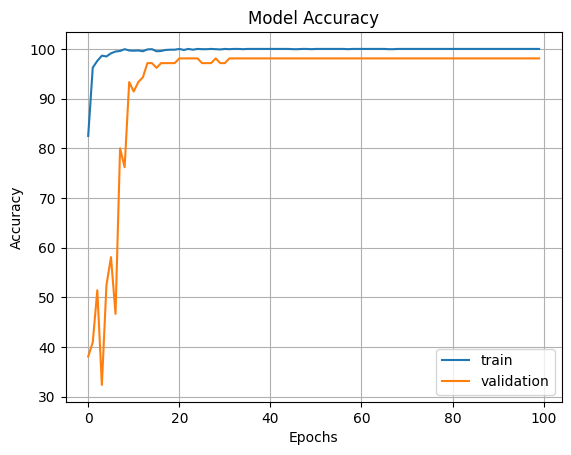

In [14]:
plt.plot(accs_train, label='Train_accuracy')
plt.plot(accs_val, label='Validation_accuracy')
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

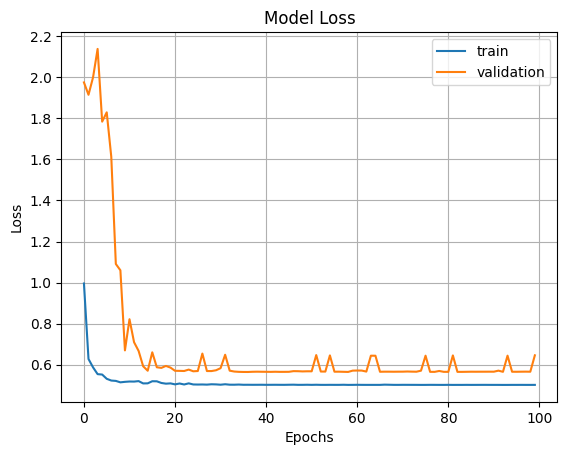

In [15]:
plt.plot(losses_train, label='Train_loss')
plt.plot(losses_val, label='Validation_loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [17]:
test = MyTestSet("./pretrained/test_pre.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [18]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./pretrained/checkpoint_model_pre.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [19]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

real_label = pd.read_csv("./pretrained/testy_pre.csv", index_col=0)
real_label.value_counts()

celltype   
alpha          41
beta           23
duct           13
acinar         11
delta           9
pp              5
mesenchymal     4
endothelial     1
unclear         1
dtype: int64

In [20]:
file = open("./pretrained/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

alpha          40
beta           31
acinar         12
duct           12
delta           7
mesenchymal     5
endothelial     1
dtype: int64

In [21]:
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype"])
ari = adjusted_rand_score(real_label_2, pred_label_2)

print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.880, ARI = 0.851
